## 데이터 다운로드
- 2012년 8월 30일 ~ 2021년 8월 29일 서울 평균 기온

In [1]:
import pandas as pd

df = pd.read_csv('../datasets/temperature.csv', encoding='cp949')
df.head(3)

,지점,지점명,일시,평균기온(°C)
0,108,서울,2012-08-30,21.4
1,108,서울,2012-08-31,23.8
2,108,서울,2012-09-01,25.2


## 데이터 가공

In [3]:
df['연'] = pd.to_datetime(df['일시']).dt.year
df['월'] = pd.to_datetime(df['일시']).dt.month
df['일'] = pd.to_datetime(df['일시']).dt.day
df.head(3)

,지점,지점명,일시,평균기온(°C),연,월,일
0,108,서울,2012-08-30,21.4,2012,8,30
1,108,서울,2012-08-31,23.8,2012,8,31
2,108,서울,2012-09-01,25.2,2012,9,1


In [4]:
df.rename(columns={'평균기온(°C)':'기온'}, inplace=True)

In [5]:
df_new = df[['연', '월', '일', '기온']]
df_new.head(3)

,연,월,일,기온
0,2012,8,30,21.4
1,2012,8,31,23.8
2,2012,9,1,25.2


In [6]:
df_new.to_csv('../datasets/temperature_preprocessed.csv', encoding='cp949')

In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연       3287 non-null   int64  
 1   월       3287 non-null   int64  
 2   일       3287 non-null   int64  
 3   기온      3287 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 102.8 KB


## 기온 평균 구하기

In [13]:
# 날짜별 기온을 리스트에 담기
md = {}
for i, row in df_new.iterrows():
    m, d, v = int(row['월']), int(row['일']), row['기온']
    key = str(m) + '/' + str(d)
    if not (key in md):
        md[key] = []
    md[key] += [v]

# 날짜별 평균 구하기
avs = {}
for key in md:
    v = avs[key] = sum(md[key]) / len(md[key])

### 책의 방법 외

In [14]:
df_new.groupby(['월', '일'])['기온'].mean()

월   일 
1   1    -1.911111
    2    -1.800000
    3    -2.111111
    4    -1.166667
    5    -1.444444
            ...   
12  27   -3.911111
    28   -2.488889
    29   -1.033333
    30   -2.366667
    31   -3.100000
Name: 기온, Length: 366, dtype: float64

In [15]:
avs['11/3']

10.533333333333335

In [16]:
df_new.groupby(['월', '일'])['기온'].mean()[11][3]

10.533333333333335

## 월별 평균 기온

C:\Users\master\anaconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\master\anaconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)


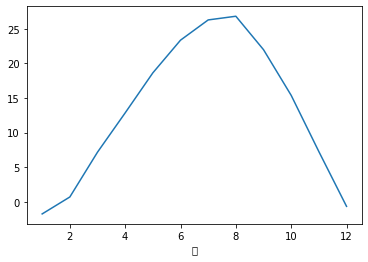

In [18]:
import matplotlib.pyplot as plt

g = df_new.groupby(['월'])['기온']
gg = g.sum() / g.count()

gg.plot()
plt.show()

## 평균 기온이 30도가 넘는 날

연
2014     2
2015     1
2016    11
2017     3
2018    24
2019     5
2020     1
2021     9
Name: 연, dtype: int64


C:\Users\master\anaconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\master\anaconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0, flags=flags)


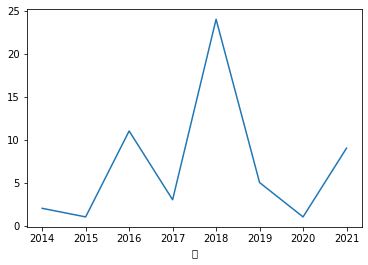

In [19]:
hot_bool = (df_new['기온'] > 30)
hot = df_new[hot_bool]

cnt = hot.groupby(['연'])['연'].count()
print(cnt)

cnt.plot()
plt.show()

## 회귀 분석으로 내일 기온 예측
- n일 동안의 과거 데이터로 다음 날의 기온을 예측

In [20]:
from sklearn.linear_model import LinearRegression

train_year = df_new['연'] <= 2020
test_year = df_new['연'] >= 2021

def make_data(data, interval=6):
    x = [] # 학습 데이터
    y = [] # 결과
    
    temps = list(data['기온'])
    for i in range(len(temps)):
        # interval보다 작으면 패스 (인터벌 만큼의 데이터가 기본적으로 필요)
        if i < interval : continue
            
        y.append(temps[i])
        
        # i번째 데이터로부터 i-1, i-2, ... i-interval의 interval 개의 데이터를 뽑아냄
        xa = []
        for p in range(interval):
            d = i + p - interval
            xa.append(temps[d])
        x.append(xa)
    return x, y

In [22]:
train_x, train_y = make_data(df_new[train_year])
test_x, test_y = make_data(df_new[test_year])

In [23]:
lr = LinearRegression()
lr.fit(train_x, train_y)
pre_y = lr.predict(test_x)

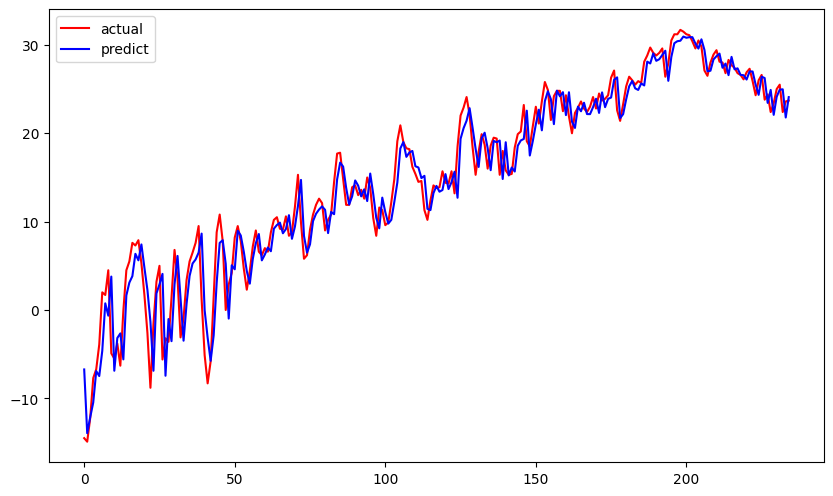

In [27]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(test_y, c='r')
plt.plot(pre_y, c='b')
plt.legend(['actual', 'predict'])
plt.show()

In [28]:
diff_y = abs(pre_y-test_y)
print('average :', sum(diff_y)/len(diff_y))
print('max =', max(diff_y))

average : 1.8667526609946516
max = 9.688004972843896


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test_y, pre_y)
rmse = np.sqrt(mean_squared_error(test_y, pre_y))

In [30]:
print('mae :', mae)
print('rmse :', rmse)

mae : 1.8667526609946523
rmse : 2.4896764778956864
